# A1_3 – MLR and PyTorch comparison against manual BP

In this notebook we compare three regression models on the same dataset:

- Multiple Linear Regression (MLR) using scikit-learn
- A custom neural network implemented from scratch (manual backprop)
- A neural network implemented with PyTorch

The goals are:

- Use exactly the same preprocessed data for all models.
- Reuse the best configuration found for the manual BP network in the previous notebook.
- Train MLR and PyTorch with comparable settings.
- Compare the models using MSE, MAE and MAPE on:
  - the 80% train+validation set,
  - the 20% test set.
- Visualize error curves and prediction quality with scatter plots.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../models")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from NeuralNet import NeuralNet                      # manual BP implementation
from mlr_sklearn import MultipleLinearRegressionSK   # simple MLR wrapper
from neuralnet_torch import NeuralNetTorch           # PyTorch NN wrapper


# Load encoded dataset

hours_encoded = pd.read_csv("../data/hours_encoded.csv")

print("Encoded dataset loaded.")
print("Shape:", hours_encoded.shape)
hours_encoded.head()


Encoded dataset loaded.
Shape: (17379, 63)


,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,cnt_log,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4
0,0,0,0.24,0.2879,0.81,0.0,3,13,16,2.833213,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0,0,0.22,0.2727,0.80,0.0,8,32,40,3.713572,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0,0,0.22,0.2727,0.80,0.0,5,27,32,3.496508,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0,0,0.24,0.2879,0.75,0.0,3,10,13,2.639057,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0,0,0.24,0.2879,0.75,0.0,0,1,1,0.693147,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [ ]:

# Define target and feature matrix


target_col = "cnt_log"

data = hours_encoded.copy()

# Drop original 'cnt' if still present (we predict cnt_log instead)
if "cnt" in data.columns:
    data = data.drop(columns=["cnt"])

# Separate features (X) and target (y)
X_df = data.drop(columns=[target_col])
y = data[target_col].values

print("Full feature matrix shape:", X_df.shape)
print("Full target vector shape :", y.shape)


# Shuffle and sample 1500 patterns

data_sampled = data.sample(n=1500, random_state=42).reset_index(drop=True)

X_df = data_sampled.drop(columns=[target_col])
y = data_sampled[target_col].values

print("\nAfter sampling 1500 rows:")
print("Feature matrix shape:", X_df.shape)
print("Target vector shape :", y.shape)


# Train / Test split (80% / 20%)

X_trainval_df, X_test_df, y_trainval, y_test = train_test_split(
    X_df, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("\nTrain+Val size:", X_trainval_df.shape[0])
print("Test size     :", X_test_df.shape[0])

# Convert to NumPy arrays
X_trainval = X_trainval_df.values
X_test = X_test_df.values

print("\nX_trainval shape:", X_trainval.shape)
print("X_test shape     :", X_test.shape)
print("y_trainval shape :", y_trainval.shape)
print("y_test shape     :", y_test.shape)


Full feature matrix shape: (17379, 61)
Full target vector shape : (17379,)

After sampling 1500 rows:
Feature matrix shape: (1500, 61)
Target vector shape : (1500,)

Train+Val size: 1200
Test size     : 300

X_trainval shape: (1200, 61)
X_test shape     : (300, 61)
y_trainval shape : (1200,)
y_test shape     : (300,)


In [ ]:

# Feature scaling (StandardScaler for X)


x_scaler = StandardScaler()
X_trainval_np = x_scaler.fit_transform(X_trainval)
X_test_np     = x_scaler.transform(X_test)


# Target scaling (StandardScaler for y)


y_scaler = StandardScaler()
y_trainval_scaled = y_scaler.fit_transform(y_trainval.reshape(-1, 1)).ravel()
y_test_scaled     = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

n_features = X_trainval_np.shape[1]
print("Number of input features:", n_features)


Number of input features: 61


In [4]:
def predict_batch(model, X):
    """
    Run model.predict on each sample in X and stack results as a column vector.

    This is useful for the manual NeuralNet implementation,
    which usually expects a single sample as input to predict().
    """
    return np.array([model.predict(x) for x in X]).reshape(-1, 1)


def mape(y_true, y_pred):
    """
    Safe MAPE implementation (ignores zero targets).

    MAPE = Mean Absolute Percentage Error (in %).
    """
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0


def evaluate_regression(y_true, y_pred):
    """
    Compute MSE, MAE and MAPE for a regression model.
    Metrics are returned in a dictionary.
    """
    mse_val = mean_squared_error(y_true, y_pred)
    mae_val = mean_absolute_error(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    return {"MSE": mse_val, "MAE": mae_val, "MAPE": mape_val}


In [ ]:

# Best configuration for manual BP, we copy here the Hyperpaarameters from the notebook 2


hidden_layers_bp = [40, 15]
epochs_bp = 600
lr_bp = 0.005
momentum_bp = 0.9
activation_bp = "tanh"

print("Manual BP selected configuration:")
print("Hidden layers :", hidden_layers_bp)
print("Epochs        :", epochs_bp)
print("Learning rate :", lr_bp)
print("Momentum      :", momentum_bp)
print("Activation    :", activation_bp)


Manual BP selected configuration:
Hidden layers : [40, 15]
Epochs        : 600
Learning rate : 0.005
Momentum      : 0.9
Activation    : tanh


In [ ]:

# 1) Manual Backprop Neural Network (selected config)


layers_bp = [n_features] + hidden_layers_bp + [1]

net_manual = NeuralNet(
    n=layers_bp,
    fact=activation_bp,
    eta=lr_bp,
    alpha=momentum_bp,
    epochs=epochs_bp,
    val_split=0.2
)

# Train on the 80% (network internally splits into train/val)
net_manual.fit(X_trainval_np, y_trainval_scaled)

# Error evolution per epoch (from NeuralNet)
train_err_manual, val_err_manual = net_manual.loss_epochs()

# --- Predictions in scaled space ---
y_trainval_pred_manual_scaled = predict_batch(net_manual, X_trainval_np)
y_test_pred_manual_scaled     = predict_batch(net_manual, X_test_np)

# --- Back to original target scale (cnt_log) ---
y_trainval_pred_manual = y_scaler.inverse_transform(y_trainval_pred_manual_scaled).ravel()
y_test_pred_manual     = y_scaler.inverse_transform(y_test_pred_manual_scaled).ravel()

# --- Metrics (in original cnt_log scale) ---
metrics_manual_trainval = evaluate_regression(y_trainval, y_trainval_pred_manual)
metrics_manual_test     = evaluate_regression(y_test,     y_test_pred_manual)

print("=== Manual BP Neural Network (selected config) ===")
print("TRAIN+VAL:", metrics_manual_trainval)
print("TEST     :", metrics_manual_test)


Neural network has been initialized
Architecture (neurons per layer): [61, 40, 15, 1]
Activation function used: tanh
 Layer 1: w(40, 61), theta(40, 1)
 Layer 2: w(15, 40), theta(15, 1)
 Layer 3: w(1, 15), theta(1, 1)
Epoch 0: Train MSE=0.112962 | Val MSE=0.065901
Epoch 100: Train MSE=0.000618 | Val MSE=0.017802
Epoch 200: Train MSE=0.000134 | Val MSE=0.017763
Epoch 300: Train MSE=0.000030 | Val MSE=0.017871
Epoch 400: Train MSE=0.000012 | Val MSE=0.017913
Epoch 500: Train MSE=0.000015 | Val MSE=0.018007
=== Manual BP Neural Network (selected config) ===
TRAIN+VAL: {'MSE': 0.014389351096046272, 'MAE': 0.039628947545721625, 'MAPE': np.float64(1.351716319241568)}
TEST     : {'MSE': 0.0730842331376131, 'MAE': 0.13369104130206205, 'MAPE': np.float64(6.780686978980843)}


In [ ]:

# 2) Multiple Linear Regression (scikit-learn)


mlr = MultipleLinearRegressionSK(fit_intercept=True)

# Train on scaled features and scaled target (same as neural networks)
mlr.fit(X_trainval_np, y_trainval_scaled)

# Predictions in scaled space
y_trainval_pred_mlr_scaled = mlr.predict(X_trainval_np).reshape(-1, 1)
y_test_pred_mlr_scaled     = mlr.predict(X_test_np).reshape(-1, 1)

# Back to original target scale (cnt_log)
y_trainval_pred_mlr = y_scaler.inverse_transform(y_trainval_pred_mlr_scaled).ravel()
y_test_pred_mlr     = y_scaler.inverse_transform(y_test_pred_mlr_scaled).ravel()

# Metrics (in original cnt_log scale)
metrics_mlr_trainval = evaluate_regression(y_trainval, y_trainval_pred_mlr)
metrics_mlr_test     = evaluate_regression(y_test,     y_test_pred_mlr)

print("=== Multiple Linear Regression (scikit-learn) ===")
print("TRAIN+VAL:", metrics_mlr_trainval)
print("TEST     :", metrics_mlr_test)


Multiple Linear Regression (scikit-learn) initialized.
fit_intercept: True
=== Multiple Linear Regression (scikit-learn) ===
TRAIN+VAL: {'MSE': 0.20247073221894374, 'MAE': 0.3161838528483779, 'MAPE': np.float64(10.622396013879069)}
TEST     : {'MSE': 0.22018721386256754, 'MAE': 0.3201973636727165, 'MAPE': np.float64(12.33237230480686)}


In [ ]:

# 3) PyTorch Neural Network (same config as manual BP)


hidden_layers_torch = hidden_layers_bp
layers_torch = [n_features] + hidden_layers_torch + [1]

net_torch = NeuralNetTorch(
    n=layers_torch,
    fact=activation_bp,   # same activation
    eta=lr_bp,            # same learning rate
    alpha=momentum_bp,    # same momentum
    epochs=epochs_bp,     # same number of epochs
    val_split=0.2         # same validation split
)

# Train with scaled data
net_torch.fit(X_trainval_np, y_trainval_scaled)

# Loss history for later plots
train_err_torch, val_err_torch = net_torch.loss_epochs()

# Predictions in scaled space
y_trainval_pred_torch_scaled = net_torch.predict(X_trainval_np).reshape(-1, 1)
y_test_pred_torch_scaled     = net_torch.predict(X_test_np).reshape(-1, 1)

# Back to original target scale (cnt_log)
y_trainval_pred_torch = y_scaler.inverse_transform(y_trainval_pred_torch_scaled).ravel()
y_test_pred_torch     = y_scaler.inverse_transform(y_test_pred_torch_scaled).ravel()

# Metrics (in original cnt_log scale)
metrics_torch_trainval = evaluate_regression(y_trainval, y_trainval_pred_torch)
metrics_torch_test     = evaluate_regression(y_test,     y_test_pred_torch)

print("=== PyTorch Neural Network (same config) ===")
print("TRAIN+VAL:", metrics_torch_trainval)
print("TEST     :", metrics_torch_test)


Neural network (PyTorch) initialized.
Layers: [61, 40, 15, 1]
Activation: tanh
Epoch 0: Train MSE=1.018194 | Val MSE=1.047000
Epoch 100: Train MSE=0.092001 | Val MSE=0.091532
Epoch 200: Train MSE=0.075472 | Val MSE=0.077281
Epoch 300: Train MSE=0.064389 | Val MSE=0.068695
Epoch 400: Train MSE=0.054747 | Val MSE=0.061339
Epoch 500: Train MSE=0.046138 | Val MSE=0.054716
=== PyTorch Neural Network (same config) ===
TRAIN+VAL: {'MSE': 0.08061158644030046, 'MAE': 0.18859135778788005, 'MAPE': np.float64(7.003202584310101)}
TEST     : {'MSE': 0.12514822801589748, 'MAE': 0.21501768777256, 'MAPE': np.float64(9.25620501207316)}


In [ ]:

# Comparison tables: TRAIN+VAL and TEST metrics


results_trainval = {
    "Model": ["Manual BP", "MLR (SK)", "PyTorch NN"],
    "MSE":   [
        metrics_manual_trainval["MSE"],
        metrics_mlr_trainval["MSE"],
        metrics_torch_trainval["MSE"],
    ],
    "MAE":   [
        metrics_manual_trainval["MAE"],
        metrics_mlr_trainval["MAE"],
        metrics_torch_trainval["MAE"],
    ],
    "MAPE":  [
        metrics_manual_trainval["MAPE"],
        metrics_mlr_trainval["MAPE"],
        metrics_torch_trainval["MAPE"],
    ],
}

results_test = {
    "Model": ["Manual BP", "MLR (SK)", "PyTorch NN"],
    "MSE":   [
        metrics_manual_test["MSE"],
        metrics_mlr_test["MSE"],
        metrics_torch_test["MSE"],
    ],
    "MAE":   [
        metrics_manual_test["MAE"],
        metrics_mlr_test["MAE"],
        metrics_torch_test["MAE"],
    ],
    "MAPE":  [
        metrics_manual_test["MAPE"],
        metrics_mlr_test["MAPE"],
        metrics_torch_test["MAPE"],
    ],
}

df_trainval = pd.DataFrame(results_trainval)
df_test     = pd.DataFrame(results_test)

print("=== TRAIN+VAL metrics (80%) ===")
display(df_trainval)

print("=== TEST metrics (20%) ===")
display(df_test)


=== TRAIN+VAL metrics (80%) ===


,Model,MSE,MAE,MAPE
0,Manual BP,0.014389,0.039629,1.351716
1,MLR (SK),0.202471,0.316184,10.622396
2,PyTorch NN,0.080612,0.188591,7.003203


=== TEST metrics (20%) ===


,Model,MSE,MAE,MAPE
0,Manual BP,0.073084,0.133691,6.780687
1,MLR (SK),0.220187,0.320197,12.332372
2,PyTorch NN,0.125148,0.215018,9.256205


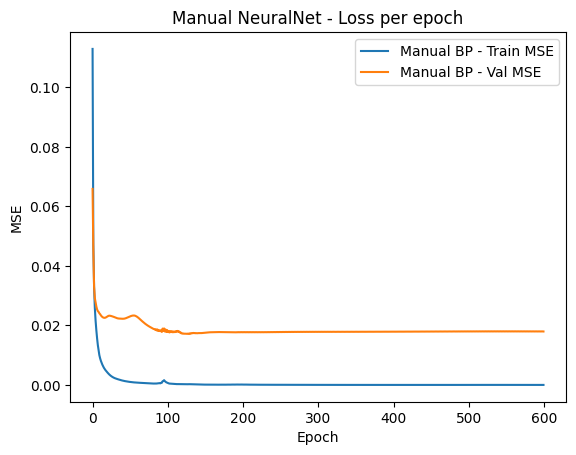

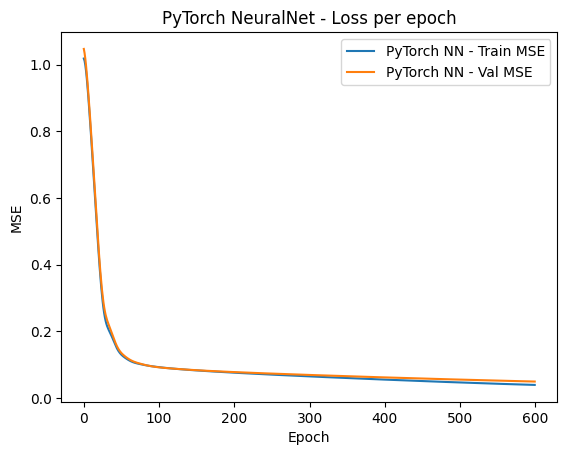

In [ ]:

# Loss curves for manual BP and PyTorch

plt.figure()
plt.plot(train_err_manual, label="Manual BP - Train MSE")
if any(e is not None for e in val_err_manual):
    plt.plot([e for e in val_err_manual if e is not None], label="Manual BP - Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Manual NeuralNet - Loss per epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_err_torch, label="PyTorch NN - Train MSE")
if any(e is not None for e in val_err_torch):
    plt.plot([e for e in val_err_torch if e is not None], label="PyTorch NN - Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("PyTorch NeuralNet - Loss per epoch")
plt.legend()
plt.show()


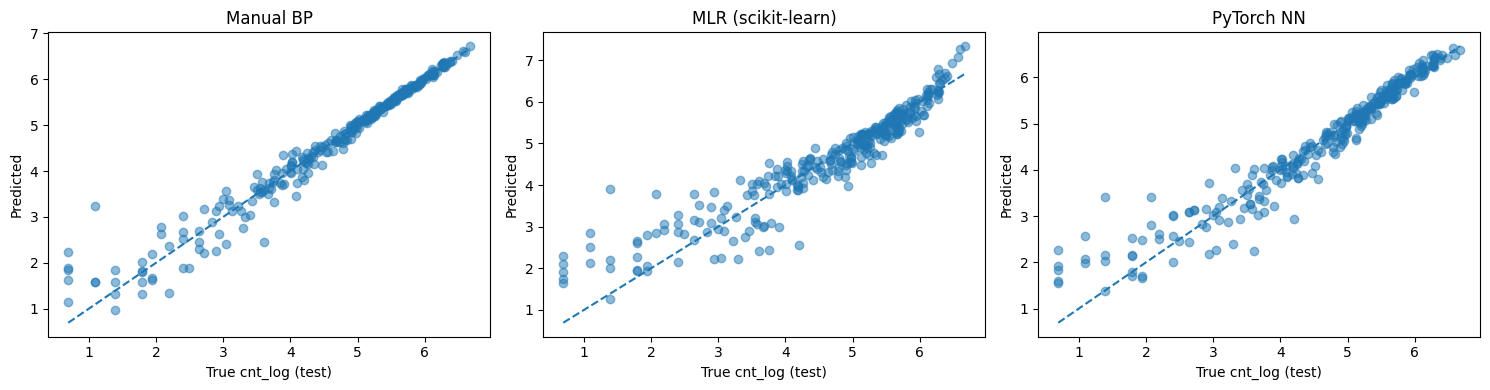

In [ ]:

# Scatter plots: true vs predicted on TEST set


plt.figure(figsize=(15, 4))

# Manual BP
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred_manual, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted")
plt.title("Manual BP")

# MLR
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred_mlr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted")
plt.title("MLR (scikit-learn)")

# PyTorch NN
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred_torch, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True cnt_log (test)")
plt.ylabel("Predicted")
plt.title("PyTorch NN")

plt.tight_layout()
plt.show()


## Summary of model comparison

In this notebook we compared three regression models on the same
Bike Sharing hourly dataset:

- **Manual BP Neural Network** (custom implementation),
- **Multiple Linear Regression (MLR)** using scikit-learn,
- **PyTorch Neural Network** using the same architecture and hyperparameters as the manual BP model.

The main points are:

- All models were trained on the same **scaled** features and target.
- The manual BP and the PyTorch models used the same:
  - number of layers and neurons,
  - activation function,
  - learning rate, momentum,
  - number of epochs,
  - internal validation split.
- We measured performance using **MSE, MAE and MAPE** on:
  - the 80% train+validation set,
  - the 20% test set.

From the comparison tables and plots we can discuss:

- How the linear model (MLR) behaves compared to the nonlinear neural networks.
- Whether PyTorch reproduces or improves the performance of the manual BP implementation.
- How stable each model is during training (by looking at the loss curves).
- How close the predictions are to the true values on the test set (scatter plots).

These results can now be used in the written report of the assignment
to justify the choice of architecture and to discuss the advantages
and limitations of each approach.
